# Python Assignment 4

## 5. Image Binary Classification (30 pts)



For Question 5 of the Python project, please complete it using two distinct Jupyter Notebook scripts. This entails using one notebook for the original dataset and another for the modified dataset. Consequently, you will be submitting a total of three .ipynb files as part of your Python project, ensuring clear separation and organization of your work.

Your tasks:
1. Your first task is to re-implement the classification model that was covered in our class. Please start from scratch and write the code independently. You can refer to the original code provided on Brightspace if you encounter any difficulties, but try to write the code on your own to reinforce your understanding.

2. After implementing the classification model, **report the indices of all the images in the test set for which the model's predictions are incorrect.** To maintain consistency with Python’s convention, please begin your indexing with 0. Additionally, **display the images of 4 of these failed cases for visual examination (you can display more if you like)**. This analysis might help us identify instances where the model is struggling in some applications.

3. Now you will modify the code to treat the dataset differently. The first 160 images plus the last digit of your Student ID will constitute the new training set, while the remaining images in the original training set will be your new test set. There are 209 images in the original training set. For example, if your ID ends with 0, the first 160 images will form your training set, and the remaining 49 images will be part of your test set. The test dataset is discarded and no longer used. Re-train the model using this modified dataset and **report the training and test accuracies**. Additionally, **provide the indices of all the images in the test set for which the model's predictions are incorrect. Display 4 of these misclassified images for further examination.**

By completing these tasks, you'll gain valuable insights into the classification model's performance and its behavior under different training and testing conditions.


  Datasets: [train]: train_catvnoncat.h5, [test]: test_catvnoncat.h5

In [ ]:
#import necessary packages
import torch
import torch.nn as nn
import torch.optim 
from torch.utils.data import DataLoader, Dataset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torchvision import transforms, models
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#image preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),       # H x W x C → PIL (RGB)
    transforms.Resize((224, 224)), #resize to ImageNet size
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),         #convert to tensor
    transforms.Normalize(          #normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

#custom Dataset for arrays
class CatDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]       #shape (64,64,3)
        label = self.y[idx]     #scalar
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([label], dtype=torch.float32)

#load full dataset from h5
with h5py.File("train_catvnoncat.h5", "r") as f:
    X_full = np.array(f["train_set_x"][:])
    y_full = np.array(f["train_set_y"][:])

print("Total original images:", X_full.shape[0])

#split index
#my SBU ID is 114404255 which ends in "5"
split_index = 160 + 5
X_train = X_full[:split_index]
y_train = y_full[:split_index]
X_test = X_full[split_index:]
y_test = y_full[split_index:]

print("New Train Size:", len(X_train))
print("New Test Size:", len(X_test))

#create datasets
train_dataset = CatDataset(X_train, y_train, transform)
test_dataset  = CatDataset(X_test, y_test, transform)

#dataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total original images: 209
New Train Size: 165
New Test Size: 44


In [4]:

#load pretrained model and replace final layer
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  #binary classification

#hyperparameters
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)

model = model.to(device)

#training loop function
def train_model(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for X, y in loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(loader):.4f}")

    print("Training complete.\n")



c:\Users\xjbar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xjbar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 | Loss: 0.7344
Epoch 2/10 | Loss: 0.6783
Epoch 3/10 | Loss: 0.5523
Epoch 4/10 | Loss: 0.4854
Epoch 5/10 | Loss: 0.3912
Epoch 6/10 | Loss: 0.4286
Epoch 7/10 | Loss: 0.3588
Epoch 8/10 | Loss: 0.4258
Epoch 9/10 | Loss: 0.3486
Epoch 10/10 | Loss: 0.3741
Training complete.

Accuracy: 75.00%

              precision    recall  f1-score   support

           0       0.95      0.68      0.79        31
           1       0.55      0.92      0.69        13

    accuracy                           0.75        44
   macro avg       0.75      0.80      0.74        44
weighted avg       0.83      0.75      0.76        44

Misclassified indices: [ 2  3 16 19 20 22 26 28 30 38 43]
Number misclassified: 11


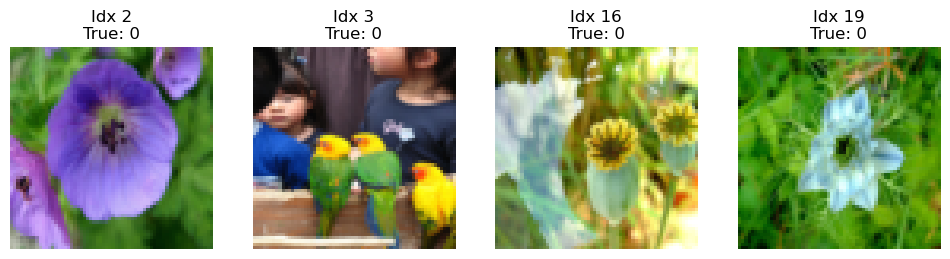

In [5]:
#evaluation function
def evaluate_model(model, loader):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)
            prob = torch.sigmoid(logits)
            pred = (prob >= 0.5).float()

            preds.extend(pred.cpu().numpy().flatten())
            trues.extend(y.numpy().flatten())

    preds = np.array(preds, dtype=np.int32)
    trues = np.array(trues, dtype=np.int32)

    acc = (preds == trues).mean() * 100.0
    print(f"Accuracy: {acc:.2f}%\n")
    print(classification_report(trues, preds))

    return preds, trues


#identify misclassified indices
def get_misclassified(loader, preds, trues):
    mis_idx = np.where(preds != trues)[0]
    print("Misclassified indices:", mis_idx)
    print("Number misclassified:", len(mis_idx))
    return mis_idx


#diaply the misclassified indices
def show_failed_examples(dataset, mis_idx, num_show=4):
    num_show = min(num_show, len(mis_idx))
    
    plt.figure(figsize=(12,4))
    for i in range(num_show):
        idx = mis_idx[i]
        img = dataset.X[idx]
        true_label = int(dataset.y[idx])

        plt.subplot(1, num_show, i+1)
        plt.imshow(img)
        plt.title(f"Idx {idx}\nTrue: {true_label}")
        plt.axis("off")
    plt.show()


#run the actual model

train_model(model, train_loader, epochs=10)

preds, trues = evaluate_model(model, test_loader)

mis_idx = get_misclassified(test_loader, preds, trues)

show_failed_examples(test_dataset, mis_idx, num_show=4)